In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings('ignore')
from jupyterthemes import jtplot
jtplot.style()
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import random

def pyRandColor():
    randNums = [random.random() for _ in range(0, 3)]

    RGB255 = list([ int(i * 255) for i in randNums ])
    RGB1 = list([ round(i, 2) for i in randNums ])
    return RGB1


## Data

In [2]:
def getData(filepath, varname='human', cols=['perplexity', 'percentage', 'entropy_rate', 'rates']):
    """
    Load and process a CSV file where the 'rates' column contains stringified lists.

    This function reads the specified columns from the CSV file, converts the 'rates' 
    column from string to list, expands each element of the list into separate columns,
    and adds a new column indicating the data category.

    Parameters:
        filepath (str): Path to the CSV file to load.
        varname (str, optional): Label for the dataset, assigned to a new 'category' column. Default is 'human'.
        cols (list of str, optional): List of columns to load from the CSV. Must include 'rates'. 
                                      Default is ['perplexity', 'percentage', 'entropy_rate', 'rates'].

    Returns:
        pd.DataFrame: Processed DataFrame with expanded 'rates' columns and a 'category' column.
    """
    import pandas as pd
    import ast  # For safely evaluating strings as Python objects

    df = pd.read_csv(filepath)[cols]
    df['rates'] = df['rates'].apply(ast.literal_eval)

    # Expand the 'rates' list into separate columns
    rates_df = df['rates'].apply(pd.Series)
    rates_df.columns = [f'rates_{i}' for i in rates_df.columns]

    # Combine expanded 'rates' columns with the rest of the DataFrame
    df_expanded = pd.concat([df.drop(columns=['rates']), rates_df], axis=1)

    return df_expanded.assign(label=varname)


## Recognition without training using averged estimate of entropy rate

In [3]:
human1=getData('../../nero/nero-data/table_data_new//gutenberg/gutenberg_detection.csv',varname=0)
human2=getData('../../nero/nero-data/table_data_new//arxiv_entropy/arxiv_table.csv',varname=0)
ai0=getData('../../nero/nero-data/table_data_new//gpt4o/gpt_4o_detection.csv',varname=1)
ai1=getData('../../nero/nero-data/table_data_new//ai_longform_gpt4o/ai_web_longform_table.csv',varname=1)
ai2=getData('../../nero/nero-data/table_data_new//ai_longform_gpt3.5/gpt_35_table.csv',varname=1)
ai3=getData('../../nero/nero-data/table_data_new//ai_longform_gpt4.0/gpt_40_table.csv',varname=1)
ai4=getData('../../nero/nero-data/table_data_new/claude_sonnet_40/claude_detection.csv',varname=1)
ai5=getData('../../nero/nero-data/table_data_new/gemini_25_pro/gemini_25_detection.csv',varname=1)
ai6=getData('../../nero/nero-data/table_data_new/gpt5/gpt_5_detection.csv',varname=1)
#ai7=getData('../nero/nero-data/table_data_new/web_article/ai_article_table.csv',varname=1)
#ai8=getData('../nero/nero-data/table_data_new/web_novel/ai_web_doped_table.csv',varname=1)
dallhuman=pd.concat([human1,human2])

df=pd.concat([human1,human2,ai0,ai1,ai2,ai3, ai4,ai5,ai6])
#df=pd.concat([human1,human2,ai1,])
NAMES={'human1':'Gutenberg project',
       'human2':'Arxiv papers',
       'ai0':'API-GPT-4o',
       'ai1':'AI Generated GPT-4o',
       'ai2':'AI Generated GPT-3.5',
       'ai3':'AI Generated GPT-4.0',
       'ai4':'Claude',
       'ai5':'Gemini',
       'ai6':'GPT-5',    
      }

In [4]:
#dh=df.copy()
df_=df.copy()
df_['nz_entropy_rate']=df[[x for x in df_.columns if 'rates' in x]].replace(0,None).median(axis=1)

def func1(row):
    n=0
    for i in row.values:
        if i == 0:
            n=n+1
    return n
nz=(df!=0).iloc[:,3:43].mean(axis=1)
nzstd=(df!=0).iloc[:,3:43].std(axis=1)
df_['nzmean'] = nz
df_['nzstd'] = nzstd
df_['nzero'] = df.apply(func1,axis=1)
#df=df.drop('nzero',axis=1)

In [5]:
ytrue=df_.label.values
ypred= df_.fillna(0).nz_entropy_rate.values #+ df.fillna(0).entropy_rate.values
#y_pred=np.median(X,axis=1)
fpr, tpr, thresholds = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e=auc(fpr, tpr)
print('nzent',auc_e)
D1=pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds}).set_index('threshold').sort_index().dropna()
#D1.to_csv('./src/neroroce.csv')

ypred=  df_.fillna(0).entropy_rate.values
#y_pred=np.median(X,axis=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e2=auc(fpr2, tpr2)
print(auc_e2)
D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()#.to_csv('./src/neroroce.csv')
pd.concat([D1,D2]).to_csv('neroroce.csv')


ypred=  df_.fillna(0).nzero.values
#y_pred=np.median(X,axis=1)
fpr3, tpr3, thresholds3 = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e3=auc(fpr3, tpr3)
print(auc_e3)
D3=pd.DataFrame({'fpr':fpr3,'tpr':tpr3,'threshold':thresholds3}).set_index('threshold').sort_index().dropna()#.to_csv('./src/neroroce.csv')
pd.concat([D1,D2,D3]).to_csv('neroroce.csv')



ypred=  df_.fillna(0).perplexity.values
#y_pred=np.median(X,axis=1)
fprP, tprP, thresholdsP = metrics.roc_curve(ytrue,ypred, pos_label=1)
auc_P=auc(fprP, tprP)
print('px',auc_P)
DP=pd.DataFrame({'fpr':fprP,'tpr':tprP,'threshold':thresholdsP}).set_index('threshold').sort_index().dropna()#.to_csv('./src/perplexity.csv')
#D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()
#pd.concat([D1,D2,DP]).to_csv('./src/neroroce.csv')


ypred=  df_.fillna(0).percentage.values
#y_pred=np.median(X,axis=1)
fprPc, tprPc, thresholdsPc = metrics.roc_curve(ytrue,ypred, pos_label=1)
auc_Pc=auc(fprPc, tprPc)
print('%->',auc_Pc)
DPc=pd.DataFrame({'fpr':fprPc,'tpr':tprPc,'threshold':thresholdsPc}).set_index('threshold').sort_index().dropna()#.to_csv('./src/perplexity.csv')
#D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()
#pd.concat([D1,D2,DP]).to_csv('./src/neroroce.csv')


nzent 0.7847100021156452
0.6058922767467996
0.6297656592604504
px 0.8208906328148864
%-> 0.9447069175214702


In [6]:
from zedstat import zedstat 
zte=zedstat.processRoc(df=pd.read_csv('neroroce.csv'),
           order=3, 
           total_samples=len(ytrue),
           positive_samples=ytrue.sum(),
           alpha=0.01,
           prevalence=.5)

zte.smooth(STEP=0.001)
zte.allmeasures(interpolate=True)
zte.usample(precision=2)
zte.getBounds()

auc_e=np.array(zte.auc(alpha=.05))*100
deltae=(auc_e[1]-auc_e[2])/2
le=str(auc_e[0])[:4]+'%'
zte.auc(alpha=.05)

(0.8205099247091033,
 np.float64(0.8303097642036211),
 np.float64(0.8107100852145857))

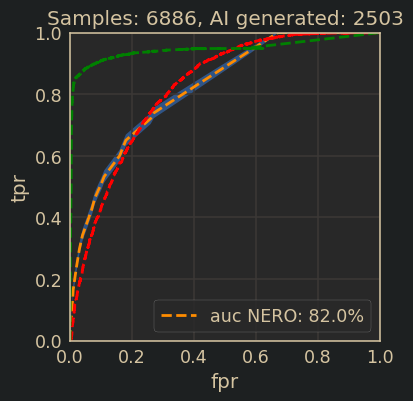

In [7]:
plt.figure(figsize=(4,4))
ax=plt.gca()
ax=zte.get().tpr.plot(style='--',ax=ax,color='darkorange',lw=2)
#ax=ztz.get().tpr.plot(style='--',ax=ax,color='green',lw=2)
plt.fill_between(x=zte.get().index, y1=zte.df_lim['U'].tpr,y2=zte.df_lim['L'].tpr, alpha=.6)

#plt.fill_between(x=ztz.get().index, y1=ztz.df_lim['U'].tpr,y2=ztz.df_lim['L'].tpr, alpha=.6)
DP.sort_values('tpr').set_index('fpr').tpr.plot(style='--',ax=ax,color='red',lw=2)
DPc.sort_values('tpr').set_index('fpr').tpr.plot(style='--',ax=ax,color='green',lw=2)

#DP.to_csv('perplexity_all.csv')
#DPc.to_csv('percentage_all.csv')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend(['auc NERO: '+le],loc='lower right')
ax.set_title('Samples: '+str(len(ytrue))+', AI generated: '+str(int(ytrue.sum())))
ax.set_ylabel('tpr');
plt.savefig('roc-notraining1.pdf',bbox_inches='tight',transparent=True)

In [8]:
#dx=pd.DataFrame({'tpr_upper':zte.df_lim['U'].tpr,'tpr_lower':zte.df_lim['L'].tpr}).join(zte.get()['tpr'])
#dx.to_csv('nero_all_notraining.csv')

In [9]:
from sklearn import metrics
df_all=pd.concat([human1,human2,ai0,ai1,ai2,ai3,ai4,ai5,ai6])
SUBSET='ALL'

In [10]:
#dh=df.copy()
df_=df_all.copy()
df_['nz_entropy_rate']=df_[[x for x in df_.columns if 'rates' in x]].replace(0,None).median(axis=1)

def func1(row):
    n=0
    for i in row.values:
        if i == 0:
            n=n+1
    return n
nz=(df_!=0).iloc[:,3:43].mean(axis=1)
nzstd=(df_!=0).iloc[:,3:43].std(axis=1)
df_['nzmean'] = nz
df_['nzstd'] = nzstd
df_['nzero'] = df_.apply(func1,axis=1)

In [11]:
ytrue=df_.label.values
ypred= df_.fillna(0).nz_entropy_rate.values #+ df.fillna(0).entropy_rate.values
#y_pred=np.median(X,axis=1)
fpr, tpr, thresholds = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e=auc(fpr, tpr)
print('nzent',auc_e)
D1=pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds}).set_index('threshold').sort_index().dropna()
#D1.to_csv('./src/neroroce.csv')

ypred=  df_.fillna(0).entropy_rate.values
#y_pred=np.median(X,axis=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e2=auc(fpr2, tpr2)
print(auc_e2)
D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()#.to_csv('./src/neroroce.csv')
pd.concat([D1,D2]).to_csv('neroroce_frac.csv')


ypred=  df_.fillna(0).nzero.values
#y_pred=np.median(X,axis=1)
fpr3, tpr3, thresholds3 = metrics.roc_curve(ytrue,ypred, pos_label=0)
auc_e3=auc(fpr3, tpr3)
print(auc_e3)
D3=pd.DataFrame({'fpr':fpr3,'tpr':tpr3,'threshold':thresholds3}).set_index('threshold').sort_index().dropna()#.to_csv('./src/neroroce.csv')
pd.concat([D1,D2,D3]).to_csv('neroroce_frac.csv')



ypred=  df_.fillna(0).perplexity.values
#y_pred=np.median(X,axis=1)
fprP, tprP, thresholdsP = metrics.roc_curve(ytrue,ypred, pos_label=1)
auc_P=auc(fprP, tprP)
print('px',auc_P)
DP=pd.DataFrame({'fpr':fprP,'tpr':tprP,'threshold':thresholdsP}).set_index('threshold').sort_index().dropna()#.to_csv('./src/perplexity.csv')
#D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()
#pd.concat([D1,D2,DP]).to_csv('./src/neroroce.csv')
DP.to_csv('perplexity_frac.csv')


ypred=  df_.fillna(0).percentage.values
#y_pred=np.median(X,axis=1)
fprPc, tprPc, thresholdsPc = metrics.roc_curve(ytrue,ypred, pos_label=1)
auc_Pc=auc(fprPc, tprPc)
print('%->',auc_Pc)
DPc=pd.DataFrame({'fpr':fprPc,'tpr':tprPc,'threshold':thresholdsPc}).set_index('threshold').sort_index().dropna()#.to_csv('./src/perplexity.csv')
DPc = DPc[~np.isinf(DPc.index)]
DPc.to_csv('percentage_frac.csv')
#D2=pd.DataFrame({'fpr':fpr2,'tpr':tpr2,'threshold':thresholds2}).set_index('threshold').sort_index().dropna()
#pd.concat([D1,D2,DP]).to_csv('./src/neroroce.csv')


nzent 0.7847100021156452
0.6058922767467996
0.6388400084625805
px 0.8208906328148864
%-> 0.9447069175214702


In [12]:
from zedstat import zedstat 
zte=zedstat.processRoc(df=pd.read_csv('neroroce_frac.csv'),
           order=3, 
           total_samples=len(ytrue),
           positive_samples=ytrue.sum(),
           alpha=0.01,
           prevalence=.5)

zte.smooth(STEP=0.001)
zte.allmeasures(interpolate=True)
zte.usample(precision=2)
zte.getBounds()

auc_e=np.array(zte.auc(alpha=.05))*100
deltae=(auc_e[1]-auc_e[2])/2
le=str(auc_e[0])[:4]+'%'
zte.auc(alpha=.05)


ztpc=zedstat.processRoc(df=pd.read_csv('percentage_frac.csv'),
           order=3, 
           total_samples=len(ytrue),
           positive_samples=ytrue.sum(),
           alpha=0.01,
           prevalence=.5)

ztpc.smooth(STEP=0.001)
ztpc.allmeasures(interpolate=True)
ztpc.usample(precision=2)
ztpc.getBounds()

auc_pc=np.array(ztpc.auc(alpha=.05))*100
deltapc=(auc_pc[1]-auc_pc[2])/2
lpc=str(auc_pc[0])[:4]+'%'
ztpc.auc(alpha=.05)



ztpx=zedstat.processRoc(df=pd.read_csv('perplexity_frac.csv'),
           order=3, 
           total_samples=len(ytrue),
           positive_samples=ytrue.sum(),
           alpha=0.01,
           prevalence=.5)

ztpx.smooth(STEP=0.001)
ztpx.allmeasures(interpolate=True)
ztpx.usample(precision=2)
ztpx.getBounds()

auc_px=np.array(ztpx.auc(alpha=.05))*100
deltapx=(auc_px[1]-auc_px[2])/2
lpx=str(auc_px[0])[:4]+'%'
ztpx.auc(alpha=.05)

(0.8230623252097483,
 np.float64(0.8325955408898799),
 np.float64(0.8135291095296169))

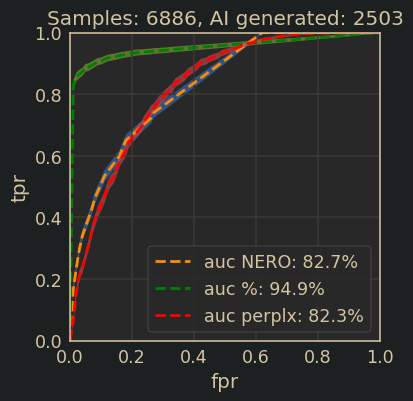

In [13]:
plt.figure(figsize=(4,4))
ax=plt.gca()
ax=zte.get().tpr.plot(style='--',ax=ax,color='darkorange',lw=2)
ax=ztpc.get().tpr.plot(style='--',ax=ax,color='green',lw=2)
ax=ztpx.get().tpr.plot(style='--',ax=ax,color='red',lw=2)

plt.fill_between(x=zte.get().index, y1=zte.df_lim['U'].tpr,y2=zte.df_lim['L'].tpr, alpha=.6)
plt.fill_between(x=ztpc.get().index, y1=ztpc.df_lim['U'].tpr,y2=ztpc.df_lim['L'].tpr, alpha=.6)
plt.fill_between(x=ztpx.get().index, y1=ztpx.df_lim['U'].tpr,y2=ztpx.df_lim['L'].tpr, alpha=.6)


dx=pd.DataFrame({'tpr_upper':zte.df_lim['U'].tpr,'tpr_lower':zte.df_lim['L'].tpr}).join(zte.get()['tpr'])
dx.to_csv('nero_'+SUBSET+'_notraining.csv')
dx=pd.DataFrame({'tpr_upper':ztpc.df_lim['U'].tpr,'tpr_lower':ztpc.df_lim['L'].tpr}).join(ztpc.get()['tpr'])
dx.to_csv('percentage_'+SUBSET+'.csv')
dx=pd.DataFrame({'tpr_upper':ztpx.df_lim['U'].tpr,'tpr_lower':ztpx.df_lim['L'].tpr}).join(ztpx.get()['tpr'])
dx.to_csv('perplexity_'+SUBSET+'.csv')


ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend(['auc NERO: '+le,'auc %: '+lpc,'auc perplx: '+lpx],loc='lower right')
ax.set_title('Samples: '+str(len(ytrue))+', AI generated: '+str(int(ytrue.sum())))
ax.set_ylabel('tpr');
plt.savefig('roc-notraining'+SUBSET+'.pdf',bbox_inches='tight',transparent=True)

# AUC distribution for subsets

In [14]:
import itertools
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import auc as sk_auc
from zedstat import zedstat
from tqdm import tqdm

def _roc_df_from_scores(ytrue, yscore, *, pos_label):
    fpr, tpr, thr = metrics.roc_curve(ytrue, yscore, pos_label=pos_label)
    df = pd.DataFrame({"threshold": thr, "fpr": fpr, "tpr": tpr}).dropna()
    # Keep finite only
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df


def _dedupe_by_fpr_keep_max_tpr(df: pd.DataFrame) -> pd.DataFrame:
    # zedstat later indexes by fpr; ensure enough unique fpr points
    df = df.sort_values("fpr")
    df = df.groupby("fpr", as_index=False)["tpr"].max()
    return df.sort_values("fpr")


def _zedstat_auc_from_roc_df(
    roc_df: pd.DataFrame,
    *,
    total_samples: int,
    positive_samples: int,
    prevalence: float,
    alpha_process: float,
    alpha_auc: float,
    smooth_step: float,
    order: int,
):
    """
    Returns (auc_percent, used_order, method_str).
    Falls back to sklearn AUC if zedstat spline bounds are impossible.
    """
    roc_df = roc_df[["fpr", "tpr"]].copy()
    roc_df = _dedupe_by_fpr_keep_max_tpr(roc_df)

    n_unique = roc_df["fpr"].nunique()
    if n_unique < 2:
        # Not even a curve
        return float("nan"), None, "nan"

    # pick a safe spline order for zedstat's spline interpolation
    safe_order = min(order, n_unique - 1)
    if safe_order < 1:
        # linear AUC directly
        return float(sk_auc(roc_df["fpr"].values, roc_df["tpr"].values) * 100.0), 1, "sklearn"

    try:
        zt = zedstat.processRoc(
            df=roc_df,
            order=safe_order,
            total_samples=total_samples,
            positive_samples=positive_samples,
            alpha=alpha_process,
            prevalence=prevalence,
        )
        zt.smooth(STEP=smooth_step)
        zt.allmeasures(interpolate=True)
        zt.usample(precision=2)
        zt.getBounds()
        auc_val = float(np.array(zt.auc(alpha=alpha_auc))[0] * 100.0)
        return auc_val, safe_order, "zedstat"
    except Exception:
        # final fallback: compute AUC directly from the deduped ROC
        return float(sk_auc(roc_df["fpr"].values, roc_df["tpr"].values) * 100.0), safe_order, "sklearn"


def compute_auc_triple_for_df(
    df_gpt5: pd.DataFrame,
    *,
    label_col: str = "label",
    entropy_rate_col: str = "entropy_rate",
    perplexity_col: str = "perplexity",
    percentage_col: str = "percentage",
    rates_col_substring: str = "rates",
    nz_slice: tuple[int, int] = (3, 43),
    prevalence: float = 0.5,
    alpha_process: float = 0.01,
    alpha_auc: float = 0.05,
    smooth_step: float = 0.001,
    order: int = 3,
    require_both_classes: bool = True,
):
    df_ = df_gpt5.copy()

    if label_col not in df_.columns:
        raise ValueError(f"Missing label column: '{label_col}'")

    ytrue = df_[label_col].values

    if require_both_classes and len(np.unique(ytrue)) < 2:
        # cannot define ROC/AUC
        return (np.nan, np.nan, np.nan)

    # nz_entropy_rate
    rate_cols = [c for c in df_.columns if rates_col_substring in c]
    if not rate_cols:
        raise ValueError(f"No columns found containing substring '{rates_col_substring}'")
    df_["nz_entropy_rate"] = df_[rate_cols].replace(0, None).median(axis=1)

    # nzero across row (as in your code)
    def func1(row):
        n = 0
        for i in row.values:
            if i == 0:
                n += 1
        return n

    lo, hi = nz_slice
    df_["nzmean"] = (df_ != 0).iloc[:, lo:hi].mean(axis=1)
    df_["nzstd"] = (df_ != 0).iloc[:, lo:hi].std(axis=1)
    df_["nzero"] = df_.apply(func1, axis=1)

    total_samples = len(ytrue)
    positive_samples = int(np.sum(ytrue))

    # --- “neroroce” composite: D1 + D2 + D3 (all with pos_label=0) ---
    roc1 = _roc_df_from_scores(ytrue, df_.fillna(0)["nz_entropy_rate"].values, pos_label=0)
    roc2 = _roc_df_from_scores(ytrue, df_.fillna(0)[entropy_rate_col].values, pos_label=0)
    roc3 = _roc_df_from_scores(ytrue, df_.fillna(0)["nzero"].values, pos_label=0)

    neroroce = pd.concat([roc1[["fpr", "tpr"]], roc2[["fpr", "tpr"]], roc3[["fpr", "tpr"]]], axis=0)
    auc_e, _, _ = _zedstat_auc_from_roc_df(
        neroroce,
        total_samples=total_samples,
        positive_samples=positive_samples,
        prevalence=prevalence,
        alpha_process=alpha_process,
        alpha_auc=alpha_auc,
        smooth_step=smooth_step,
        order=order,
    )

    # --- percentage (pos_label=1) ---
    roc_pc = _roc_df_from_scores(ytrue, df_.fillna(0)[percentage_col].values, pos_label=1)
    auc_pc, _, _ = _zedstat_auc_from_roc_df(
        roc_pc[["fpr", "tpr"]],
        total_samples=total_samples,
        positive_samples=positive_samples,
        prevalence=prevalence,
        alpha_process=alpha_process,
        alpha_auc=alpha_auc,
        smooth_step=smooth_step,
        order=order,
    )

    # --- perplexity (pos_label=1) ---
    roc_px = _roc_df_from_scores(ytrue, df_.fillna(0)[perplexity_col].values, pos_label=1)
    auc_px, _, _ = _zedstat_auc_from_roc_df(
        roc_px[["fpr", "tpr"]],
        total_samples=total_samples,
        positive_samples=positive_samples,
        prevalence=prevalence,
        alpha_process=alpha_process,
        alpha_auc=alpha_auc,
        smooth_step=smooth_step,
        order=order,
    )

    return auc_e, auc_pc, auc_px


def auc_triples_over_subsets(
    dfs: dict[str, pd.DataFrame],
    *,
    human_keys=("human1", "human2"),
    ai_keys=("ai0", "ai1", "ai2", "ai3", "ai4", "ai5", "ai6"),
    min_humans=1,
    min_ais=1,
    human_subset_sizes=(1,),
    ai_subset_sizes=(1,),
    drop_nan_triples=True,
    **auc_kwargs,
) -> pd.DataFrame:
    missing = [k for k in (*human_keys, *ai_keys) if k not in dfs]
    if missing:
        raise KeyError(f"Missing dfs entries for: {missing}")

    rows = []
    for hs in human_subset_sizes:
        for humans_sel in itertools.combinations(human_keys, hs):
            for asz in tqdm(ai_subset_sizes):
                for ais_sel in itertools.combinations(ai_keys, asz):
                    if len(humans_sel) < min_humans or len(ais_sel) < min_ais:
                        continue
                    chosen = list(humans_sel) + list(ais_sel)
                    df_cat = pd.concat([dfs[k] for k in chosen], axis=0, ignore_index=True)

                    a1, a2, a3 = compute_auc_triple_for_df(df_cat, **auc_kwargs)

                    if drop_nan_triples and (np.isnan(a1) or np.isnan(a2) or np.isnan(a3)):
                        continue

                    rows.append(
                        {
                            "humans": tuple(humans_sel),
                            "ais": tuple(ais_sel),
                            "n_humans": len(humans_sel),
                            "n_ais": len(ais_sel),
                            "auc_neroroc": a1,
                            "auc_percentage": a2,
                            "auc_perplexity": a3,
                            "auc_mean": np.nanmean([a1, a2, a3]),
                        }
                    )

    out = pd.DataFrame(rows)
    if len(out):
        out = out.sort_values("auc_mean", ascending=False)
    return out

In [15]:
%%time
dfs = {"human1": human1, "human2": human2, "ai0": ai0,"ai1": ai1, "ai2": ai2, "ai3": ai3, "ai4": ai4, "ai5": ai5, "ai6": ai6}

res = auc_triples_over_subsets(
    dfs,
    human_subset_sizes=(1, 2),
    ai_subset_sizes=tuple(range(1, 8))
)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

interpolation failed


  0%|                                                     | 0/7 [00:00<?, ?it/s]

interpolation failed
interpolation failed


 14%|██████▍                                      | 1/7 [00:17<01:43, 17.33s/it]

interpolation failed
interpolation failed


 29%|████████████▊                                | 2/7 [01:09<03:09, 37.93s/it]

interpolation failed


  0%|                                                     | 0/7 [00:00<?, ?it/s]

interpolation failed


100%|█████████████████████████████████████████████| 7/7 [05:46<00:00, 49.44s/it]

CPU times: user 16min 45s, sys: 2.64 s, total: 16min 48s
Wall time: 16min 55s


In [16]:
import numpy as np
from scipy import stats

alpha=0.01
pct=int(np.round(100*(1-alpha),0))
def mean_ci(x, alpha=alpha):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 2:
        return np.nan, np.nan, np.nan

    mu = x.mean()
    s = x.std(ddof=1)
    se = s / np.sqrt(n)

    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    lo = mu - tcrit * se
    hi = mu + tcrit * se
    return mu, lo, hi


m_e, lo_e, hi_e   = mean_ci(res.auc_neroroc)
m_px, lo_px, hi_px = mean_ci(res.auc_perplexity)
m_pc, lo_pc, hi_pc = mean_ci(res.auc_percentage)

print(f"NeuroROC AUC   : {m_e:.3f}  ({pct}% CI [{lo_e:.3f}, {hi_e:.3f}])")
print(f"Perplexity AUC : {m_px:.3f}  ({pct}% CI [{lo_px:.3f}, {hi_px:.3f}])")
print(f"Percentage AUC : {m_pc:.3f}  ({pct}% CI [{lo_pc:.3f}, {hi_pc:.3f}])")


NeuroROC AUC   : 87.837  (99% CI [87.012, 88.662])
Perplexity AUC : 87.245  (99% CI [86.276, 88.213])
Percentage AUC : 92.307  (99% CI [91.195, 93.419])


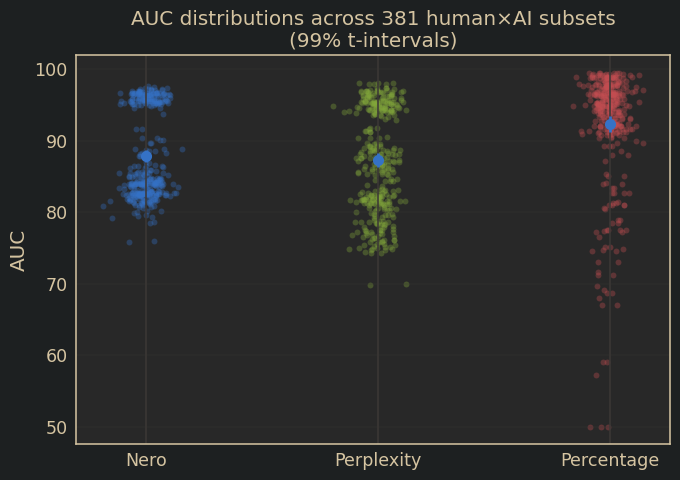

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Collect data
labels = ["Nero", "Perplexity", "Percentage"]
data = [
    np.asarray(res.auc_neroroc, dtype=float),
    np.asarray(res.auc_perplexity, dtype=float),
    np.asarray(res.auc_percentage, dtype=float),
]

means, los, his = [], [], []
for x in data:
    m, lo, hi = mean_ci(x)
    means.append(m)
    los.append(lo)
    his.append(hi)

xpos = np.arange(len(labels))

plt.figure(figsize=(7,5))

# Scatter points with jitter
rng = np.random.default_rng(0)
for i, x in enumerate(data):
    x = x[~np.isnan(x)]
    jitter = rng.normal(0, 0.05, size=len(x))
    plt.scatter(
        np.full_like(x, xpos[i]) + jitter,
        x,
        alpha=0.35,
        s=18,
        linewidths=0
    )

# Error bars (mean ± CI)
yerr = np.vstack([
    np.array(means) - np.array(los),
    np.array(his) - np.array(means)
])

plt.errorbar(
    xpos,
    means,
    yerr=yerr,
    fmt='o',
    capsize=6,
    markersize=8,
    linewidth=2,
    zorder=10
)

plt.xticks(xpos, labels)
plt.ylabel("AUC")
plt.title(f"AUC distributions across 381 human×AI subsets\n({pct}% t-intervals)")
plt.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


In [18]:
res

,humans,ais,n_humans,n_ais,auc_neroroc,auc_percentage,auc_perplexity,auc_mean
131,"(human2,)","(ai4,)",1,1,97.607143,97.611229,96.755826,97.324733
142,"(human2,)","(ai1, ai4)",1,2,97.369048,97.410269,96.622841,97.134052
149,"(human2,)","(ai3, ai4)",1,2,97.511905,96.898985,96.781726,97.064205
137,"(human2,)","(ai0, ai4)",1,2,97.273810,97.721296,96.076852,97.023986
174,"(human2,)","(ai1, ai3, ai4)",1,3,97.273810,96.771006,96.651431,96.898749
...,...,...,...,...,...,...,...,...
55,"(human1,)","(ai2, ai3, ai6)",1,3,81.670928,68.621302,94.220414,81.504215
272,"(human1, human2)","(ai2, ai3)",2,2,88.548483,59.000000,93.407801,80.318761
18,"(human1,)","(ai2, ai3)",1,2,88.494817,59.000000,93.347518,80.280778
256,"(human1, human2)","(ai2,)",2,1,94.606662,50.000000,94.205000,79.603887


In [19]:
import numpy as np
import pandas as pd

# ---- 1) scatter points (jittered) dataframe ----
labels = ["Nero", "Perplexity", "Percentage"]
data = [
    np.asarray(res.auc_neroroc, dtype=float),
    np.asarray(res.auc_perplexity, dtype=float),
    np.asarray(res.auc_percentage, dtype=float),
]

rng = np.random.default_rng(0)

rows = []
for i, (lab, x) in enumerate(zip(labels, data)):
    x = x[~np.isnan(x)]
    jitter = rng.normal(0, 0.05, size=len(x))
    for y, j in zip(x, jitter):
        rows.append(
            {
                "metric": lab,
                "x_center": i,          # integer category position
                "x_jitter": float(j),   # jitter added
                "x": float(i + j),      # final x used in scatter
                "auc": float(y),
            }
        )

df_scatter = pd.DataFrame(rows)
df_scatter.to_csv("auc_scatter_pgf.csv", index=False)

# ---- 2) summary (mean + CI) dataframe ----
summ_rows = []
for i, lab in enumerate(labels):
    mu, lo, hi = mean_ci(df_scatter.loc[df_scatter.metric == lab, "auc"].values)
    summ_rows.append(
        {
            "metric": lab,
            "x": i,
            "mean": float(mu),
            "ci_lo": float(lo),
            "ci_hi": float(hi),
            "err_lo": float(mu - lo),   # for pgfplots y error bars if desired
            "err_hi": float(hi - mu),
            "alpha": float(alpha),
            "pct": int(pct),
            "n": int(df_scatter.loc[df_scatter.metric == lab, "auc"].shape[0]),
        }
    )

df_summary = pd.DataFrame(summ_rows)
df_summary.to_csv("auc_summary_pgf.csv", index=False)

print("Wrote:", "auc_scatter_pgf.csv", "auc_summary_pgf.csv")
display(df_summary)
display(df_scatter)


Wrote: auc_scatter_pgf.csv auc_summary_pgf.csv


,metric,x,mean,ci_lo,ci_hi,err_lo,err_hi,alpha,pct,n
0,Nero,0,87.836793,87.012008,88.661578,0.824785,0.824785,0.01,99,381
1,Perplexity,1,87.244686,86.276168,88.213204,0.968518,0.968518,0.01,99,381
2,Percentage,2,92.307052,91.194623,93.419481,1.112429,1.112429,0.01,99,381


,metric,x_center,x_jitter,x,auc
0,Nero,0,0.006287,0.006287,97.607143
1,Nero,0,-0.006605,-0.006605,97.369048
2,Nero,0,0.032021,0.032021,97.511905
3,Nero,0,0.005245,0.005245,97.273810
4,Nero,0,-0.026783,-0.026783,97.273810
...,...,...,...,...,...
1138,Percentage,2,-0.014901,1.985099,68.621302
1139,Percentage,2,-0.014279,1.985721,59.000000
1140,Percentage,2,-0.028329,1.971671,59.000000
1141,Percentage,2,-0.007679,1.992321,50.000000


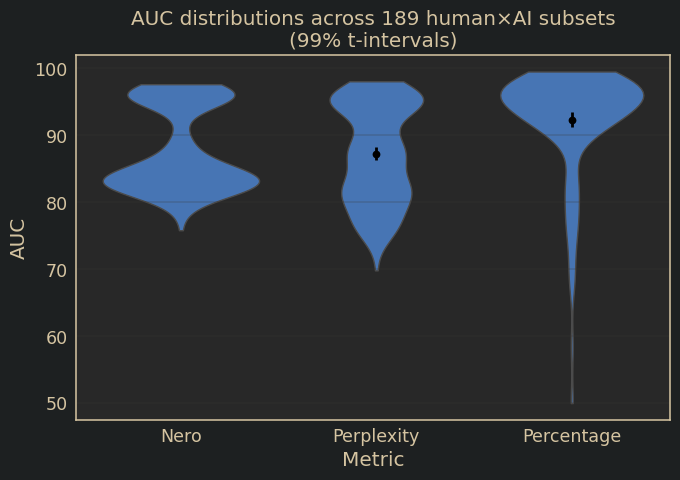

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare long-form dataframe
df_plot = pd.DataFrame({
    "AUC": np.concatenate([
        np.asarray(res.auc_neroroc, dtype=float),
        np.asarray(res.auc_perplexity, dtype=float),
        np.asarray(res.auc_percentage, dtype=float),
    ]),
    "Metric": (
        ["Nero"] * len(res.auc_neroroc)
        + ["Perplexity"] * len(res.auc_perplexity)
        + ["Percentage"] * len(res.auc_percentage)
    )
}).dropna()

plt.figure(figsize=(7,5))

sns.violinplot(
    data=df_plot,
    x="Metric",
    y="AUC",
    inner=None,          # no quartile bars
    cut=0,               # don't extend beyond data
    linewidth=1
)

# Overlay mean + CI
metrics = ["NeuroROC", "Perplexity", "Percentage"]
for i, m in enumerate(metrics):
    vals = df_plot.loc[df_plot.Metric == m, "AUC"].values
    mu, lo, hi = mean_ci(vals)
    plt.errorbar(
        i,
        mu,
        yerr=[[mu - lo], [hi - mu]],
        fmt="o",
        color="black",
        capsize=6,
        linewidth=2,
        zorder=10
    )

plt.ylabel("AUC")
plt.title(f"AUC distributions across 189 human×AI subsets\n({pct}% t-intervals)")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


# Classifier 

In [21]:
def func(Z,name_):
    if name_ in ['svm','gaussianp']:
        return Z[:,XSEL]
    return Z
y=df_.label.values+0
X=df_.drop(['perplexity','percentage','label'],axis=1).values

In [22]:
## We are prepraing a classification test train split, where we dont include the latest ai models at all for training to test future-proofness

df_for_classifier=pd.concat([human1,human2,ai0,ai1,ai2,ai3,ai4,ai5])
df_for_classifier_ai_test_future=pd.concat([ai6])

# Full classification pool
df_classification = df_for_classifier.reset_index(drop=True)

# Reproducibility
rng = np.random.default_rng(42)

# Randomly select half the rows for training
n = len(df_classification)
train_idx = rng.choice(n, size=n // 2, replace=False)

df_train = df_classification.iloc[train_idx]

# The remaining half becomes part of the test set
df_test_in_domain = df_classification.drop(train_idx)

# Final test set = remaining half + future AI data
df_test = pd.concat(
    [df_test_in_domain, df_for_classifier_ai_test_future],
    axis=0,
    ignore_index=True
)
X_train = df_train.drop(['perplexity','percentage','label'],axis=1).values
y_train = df_train.label.values+0
X_test = df_test.drop(['perplexity','percentage','label'],axis=1).values
y_test = df_test.label.values+0

#display(df_train)
#display(df_test)

In [23]:
df_.columns

Index(['perplexity', 'percentage', 'entropy_rate', 'rates_0', 'rates_1',
       'rates_2', 'rates_3', 'rates_4', 'rates_5', 'rates_6', 'rates_7',
       'rates_8', 'rates_9', 'rates_10', 'rates_11', 'rates_12', 'rates_13',
       'rates_14', 'rates_15', 'rates_16', 'rates_17', 'rates_18', 'rates_19',
       'rates_20', 'rates_21', 'rates_22', 'rates_23', 'rates_24', 'rates_25',
       'rates_26', 'rates_27', 'rates_28', 'rates_29', 'rates_30', 'rates_31',
       'rates_32', 'rates_33', 'rates_34', 'rates_35', 'rates_36', 'rates_37',
       'rates_38', 'rates_39', 'rates_40', 'label', 'nz_entropy_rate',
       'nzmean', 'nzstd', 'nzero'],
      dtype='object')

In [25]:
%%time
from sklearn import metrics
IMPUTE=True

if IMPUTE:
    from sklearn.impute import SimpleImputer
    # Impute missing values with zeros
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.fit_transform(X_test)
    X = imputer.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

modelnames=[
    'randomforest',
    #'extratrees','adaboost','gradientboost','svm',
    'gaussianp']
models = [RandomForestClassifier(n_estimators = 2500,class_weight='balanced').fit(X_train, y_train),
          #ExtraTreesClassifier(n_estimators = 2500,class_weight='balanced').fit(X_train, y_train),
          #AdaBoostClassifier(n_estimators=2000).fit(X_train, y_train),
          #GradientBoostingClassifier(n_estimators = 2500).fit(X_train, y_train),
          #svm.SVC(probability=True).fit(X_train, y_train),
         GaussianProcessClassifier(kernel=1.0 * RBF(1.0)).fit(X_train, y_train)
         ]
y_preds = [model.predict_proba(X_test) for model,modelname in zip(models,modelnames)]
auc_scores={}
ROC={}
for modelname,y_pred in zip(modelnames,y_preds):
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1] , pos_label=1)
    auc_scores[modelname] = auc(fpr, tpr)
    ROC[modelname]={'fpr':fpr,'tpr':tpr,'thresholds':thresholds}
print(auc_scores)

{'randomforest': 0.9201494659695612, 'gaussianp': 0.9944756725932262}
CPU times: user 12min 53s, sys: 14.6 s, total: 13min 8s
Wall time: 2min 9s


<Axes: >

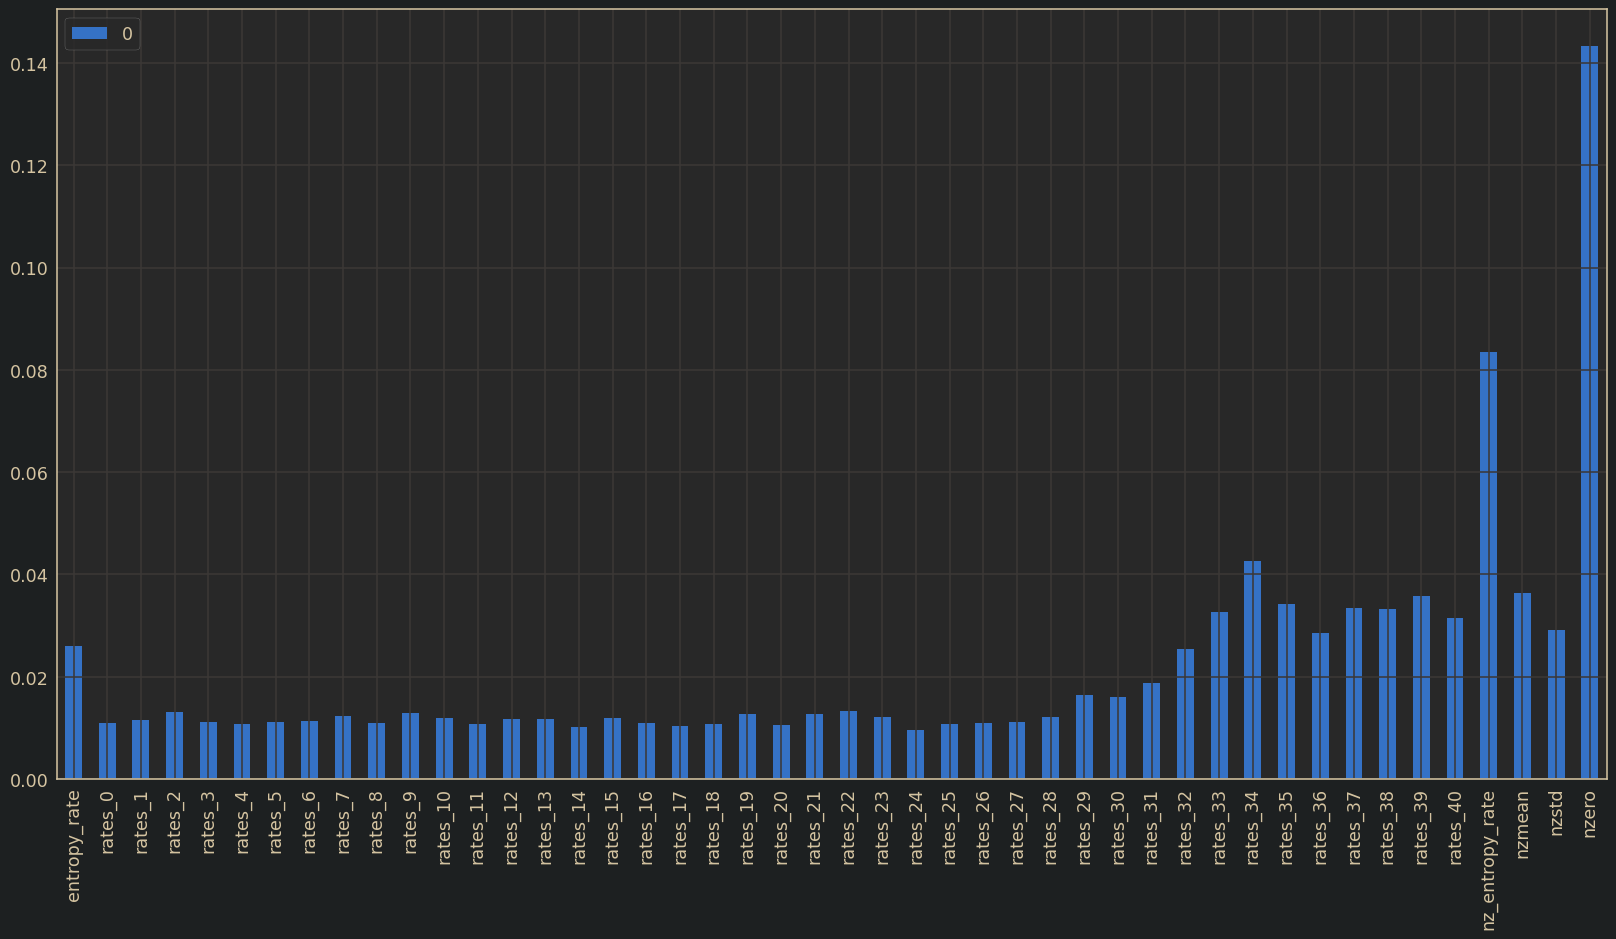

In [26]:
plt.figure(figsize=[20,10])
pd.DataFrame(models[0].feature_importances_,[x for x in df_.columns if x not in ['perplexity','percentage', 'label']]).plot(ax=plt.gca(),kind='bar')


In [27]:
modeldf_=[pd.DataFrame(ROC[model_]) for model_ in modelnames]
ztc=zedstat.processRoc(df=modeldf_[-1],
           order=3, 
           total_samples=len(y_test),
           positive_samples=y_test.sum(),
           alpha=0.01,
           prevalence=.5)

ztc.smooth(STEP=0.001)
ztc.allmeasures(interpolate=True)
ztc.usample(precision=2)
ztc.getBounds()

auc_c=np.array(ztc.auc(alpha=.05))*100
deltac=(auc_c[1]-auc_c[2])/2
lc=str(auc_c[0])[:4]+'%'
ztc.auc(alpha=.05)

(0.9906513105639396,
 np.float64(0.9928897209027288),
 np.float64(0.9884129002251505))

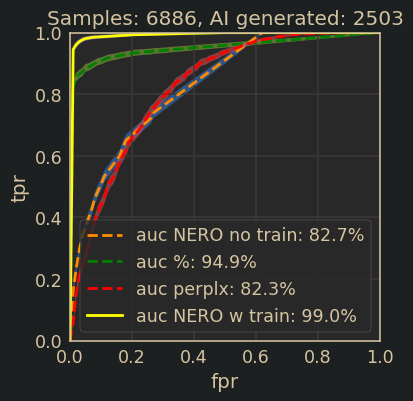

In [28]:
plt.figure(figsize=(4,4))
ax=plt.gca()
ax=zte.get().tpr.plot(style='--',ax=ax,color='darkorange',lw=2)
ax=ztpc.get().tpr.plot(style='--',ax=ax,color='green',lw=2)
ax=ztpx.get().tpr.plot(style='--',ax=ax,color='red',lw=2)
ax=ztc.get().tpr.plot(style='-',ax=ax,color='yellow',lw=2)

plt.fill_between(x=zte.get().index, y1=zte.df_lim['U'].tpr,y2=zte.df_lim['L'].tpr, alpha=.6)
plt.fill_between(x=ztpc.get().index, y1=ztpc.df_lim['U'].tpr,y2=ztpc.df_lim['L'].tpr, alpha=.6)
plt.fill_between(x=ztpx.get().index, y1=ztpx.df_lim['U'].tpr,y2=ztpx.df_lim['L'].tpr, alpha=.6)
plt.fill_between(x=ztc.get().index, y1=ztc.df_lim['U'].tpr,y2=ztc.df_lim['L'].tpr, alpha=.6)


dx=pd.DataFrame({'tpr_upper':zte.df_lim['U'].tpr,'tpr_lower':zte.df_lim['L'].tpr}).join(zte.get()['tpr'])
dx.to_csv('nero_'+SUBSET+'_notraining.csv')
dx=pd.DataFrame({'tpr_upper':ztpc.df_lim['U'].tpr,'tpr_lower':ztpc.df_lim['L'].tpr}).join(ztpc.get()['tpr'])
dx.to_csv('percentage_'+SUBSET+'.csv')
dx=pd.DataFrame({'tpr_upper':ztpx.df_lim['U'].tpr,'tpr_lower':ztpx.df_lim['L'].tpr}).join(ztpx.get()['tpr'])
dx.to_csv('perplexity_'+SUBSET+'.csv')
dx=pd.DataFrame({'tpr_upper':ztc.df_lim['U'].tpr,'tpr_lower':ztc.df_lim['L'].tpr}).join(ztc.get()['tpr'])
dx.to_csv('nero_'+SUBSET+'_trained.csv')


ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend(['auc NERO no train: '+le,'auc %: '+lpc,'auc perplx: '+lpx, 'auc NERO w train: '+lc],loc='lower right')
ax.set_title('Samples: '+str(len(ytrue))+', AI generated: '+str(int(ytrue.sum())))
ax.set_ylabel('tpr');
plt.savefig('roc-notraining'+SUBSET+'.pdf',bbox_inches='tight',transparent=True)

In [29]:
! ls -lhtr


total 6.3M
-rw-r--r-- 1 ishanu ishanu 295K Dec 26 23:04 classifier-latest5.ipynb
-rw-r--r-- 1 ishanu ishanu 673K Jan  4 22:19 classifier-latest4.ipynb
-rw-r--r-- 1 ishanu ishanu  777 Jan 11 12:00 lengthdata.csv
-rw-r--r-- 1 ishanu ishanu 2.9M Jan 11 12:03 allhuman.csv
-rw-r--r-- 1 ishanu ishanu  60K Jan 11 12:03 ai4o.csv
-rw-r--r-- 1 ishanu ishanu  57K Jan 11 12:03 ai35.csv
-rw-r--r-- 1 ishanu ishanu 233K Jan 11 12:03 updated_progess_median_entropy_rate.png
-rw-r--r-- 1 ishanu ishanu  21K Jan 11 12:55 roc-notraining_frac.pdf
-rw-r--r-- 1 ishanu ishanu 5.9K Jan 11 14:36 nero_gpt3and40_notraining.csv
-rw-r--r-- 1 ishanu ishanu 6.1K Jan 11 14:36 percentage_gpt3and40.csv
-rw-r--r-- 1 ishanu ishanu 4.9K Jan 11 14:36 perplexity_gpt3and40.csv
-rw-r--r-- 1 ishanu ishanu  21K Jan 11 14:36 roc-notraininggpt3and40.pdf
-rw-r--r-- 1 ishanu ishanu 6.0K Jan 11 18:12 nero_gpt5_notraining.csv
-rw-r--r-- 1 ishanu ishanu 6.1K Jan 11 18:12 percentage_gpt5.csv
-rw-r--r-- 1 ishanu ishanu 4.6K Jan 11 18:12 p

# Length Results

In [30]:
import sys,os
import json
import pandas as pd
import regex as re
import shutil
import numpy as np

# natural sorting implementation 
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

DATAPATH='../../nero/nero-data/length_roc_data/'
PATHS=DATAPATH+np.array(['./1k/rates','./10k/rates','./50k/rates','./100k/rates','./125k/rates','./150k/rates'])

In [31]:
import glob
import numpy as np

import json
from pathlib import Path
H={}
A={}
AH={}
AH['human']={}
AH['ai']={}
AH['humanstd']={}
AH['aistd']={}
for PATH in PATHS:
    jsonFILES_human=glob.glob(PATH+'/Guten*json')
    jsonFILES_ai=glob.glob(PATH+'/ai*json')
    H[PATH]=[]
    A[PATH]=[]
    
    for path_ in jsonFILES_human:
        # path to the JSON file
        json_path = Path(path_)
        
        with json_path.open("r") as f:
            data = json.load(f)
        
        # extract entropy_rate as a Python list (array-like)
        entropy_rate = data["entropy_rate"]
        H[PATH]=H[PATH]+[pd.DataFrame(entropy_rate).replace(0,None).median().values[0]]
    for path_ in jsonFILES_ai:
        # path to the JSON file
        json_path = Path(path_)
        
        with json_path.open("r") as f:
            data = json.load(f)
        
        # extract entropy_rate as a Python list (array-like)
        entropy_rate = data["entropy_rate"]
        A[PATH]=A[PATH]+[pd.DataFrame(entropy_rate).replace(0,None).median().values[0]]
    AH['human'][PATH]=np.nanmean(H[PATH])
    AH['ai'][PATH]=np.nanmean(A[PATH])
    AH['humanstd'][PATH]=np.nanstd(H[PATH])
    AH['aistd'][PATH]=np.nanstd(A[PATH])
    

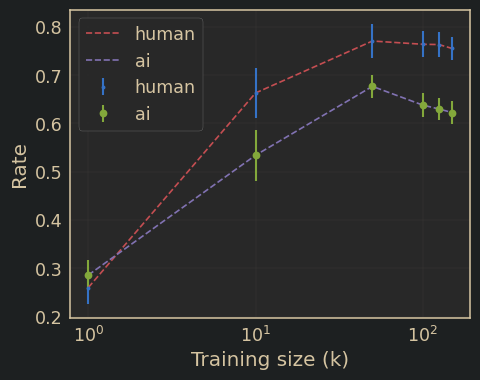

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- data ----
df = pd.DataFrame(AH)
df.index.name = "path"
df = df.reset_index()

df["k"] = df["path"].str.extract(r"(\d+)k", expand=False).astype(int)
df = df.sort_values("k").reset_index(drop=True)

# ---- CI via Student-t (z not hardcoded) ----
n = 100
alpha = 0.01
dfree = n - 1

# t critical value for two-sided (1-alpha) CI
tcrit = float(np.abs(np.quantile(np.random.standard_t(dfree, size=2_000_000), 1 - alpha/2)))

df["human_ci"] = tcrit * (df["humanstd"] / np.sqrt(n))
df["ai_ci"]    = tcrit * (df["aistd"]    / np.sqrt(n))

# ---- plot: scatter w/ error bars, no lines ----
plt.figure(figsize=(5, 4))
ax = plt.gca()

ax.errorbar(df["k"], df["human"], yerr=df["human_ci"],
            fmt=".", linestyle="none", capsize=4, elinewidth=1.5, label="human")
ax.errorbar(df["k"], df["ai"], yerr=df["ai_ci"],
            fmt="o", linestyle="none", capsize=4, elinewidth=1.5, label="ai")

df.set_index('k').human.plot(style='--')
df.set_index('k').ai.plot(style='--')
ax.set_xlabel("Training size (k)")
ax.set_ylabel("Rate")
ax.set_xticks(df["k"].tolist())
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.tight_layout()
#plt.show()
plt.savefig('len.png',dpi=300,bbox_inches='tight')

In [33]:
df.drop('path',axis=1).to_csv('lengthcomp.csv')

# Birth timeline

In [34]:
def getSTATz(df__,nm):
    a=df__[[x for x in df_.columns if 'rates' in x]].replace(0,None).median(axis=1)
    return pd.DataFrame({'mean_':a.mean(),'median_':a.median(),'std_':a.std()},index=[nm])
#getSTATz(human1,'xx')

In [35]:
NAMES={'human1':'Gutenberg project',
       'human2':'Arxiv papers',
       'ai0':'GPT-4o2',
       'ai1':'GPT-4o',
       'ai2':'GPT-3.5',
       'ai3':'GPT-4.0',
       'ai4':'Claude',
       'ai5':'Gemini',
       'ai6':'GPT-5',    
      }


df_['nz_entropy_rate']=df_[[x for x in df_.columns if 'rates' in x]].replace(0,None).median(axis=1)



tfz=pd.concat([getSTATz(human1,NAMES['human1']),
           getSTATz(human2,NAMES['human2']),
          getSTATz(ai0,NAMES['ai0']),
          getSTATz(ai1,NAMES['ai1']),
          getSTATz(ai2,NAMES['ai2']),
           getSTATz(ai3,NAMES['ai3']),
              getSTATz(ai4,NAMES['ai4']),
              getSTATz(ai5,NAMES['ai5']),
              getSTATz(ai6,NAMES['ai6']),
          ])\
.assign(count=[len(human1),len(human2),len(ai0),len(ai1),len(ai2),len(ai3),len(ai4),len(ai5),len(ai6)]).reset_index()
tfz.columns=['data source','mean H','median H','std. dev. H','count']
tfz['data source']=['Gutenberg project', 'Arxiv papers', 'GPT-4o (API)', 'GPT-4o (webform)',
       'GPT-3.5 (webform)', 'GPT-4.0 (webform)', 'Claude (API)', 'Gemini (API)', 'GPT-5 (API)']

from zedstat.textable import textable
textable(tfz.sort_values('mean H'),tabname='../../tex/overleaf/Figures/corpus.tex',FORMAT='%1.2f',TABFORMAT='lllll',LNTERM='\\\\\n',INDEX=False)
display(tfz.set_index('data source').sort_values('mean H'))#.astype(float).sort_values('median H'))


! cat ../../tex/overleaf/Figures/corpus.tex

,mean H,median H,std. dev. H,count
data source,,,,
GPT-3.5 (webform),0.537258,0.533225,0.105370,100
GPT-4o (webform),0.623759,0.627382,0.088751,98
GPT-4o (API),0.644955,0.656442,0.089853,136
Gemini (API),0.664616,0.674492,0.102502,987
Claude (API),0.711087,0.716163,0.063883,944
GPT-4.0 (webform),0.712455,0.709214,0.087903,41
GPT-5 (API),0.742249,0.738553,0.075496,197
Gutenberg project,0.773291,0.775335,0.121334,4341
Arxiv papers,1.319029,1.190748,0.554563,42


\begin{tabular}{lllll}\hline
 data  source & mean  H & median  H & std.  dev.  H &count\\\hline
 GPT-3.5  (webform) &0.54&0.53&0.11&100\\
 GPT-4o  (webform) &0.62&0.63&0.09&98\\
 GPT-4o  (API) &0.64&0.66&0.09&136\\
 Gemini  (API) &0.66&0.67&0.10&987\\
 Claude  (API) &0.71&0.72&0.06&944\\
 GPT-4.0  (webform) &0.71&0.71&0.09&41\\
 GPT-5  (API) &0.74&0.74&0.08&197\\
 Gutenberg  project &0.77&0.78&0.12&4341\\
 Arxiv  papers &1.32&1.19&0.55&42\\
\hline\end{tabular}


In [36]:
tfz['data source'].values 
tfz['data source']=['Gutenberg project', 'Arxiv papers', 'GPT-4o', 'GPT-4o (Webform)',
       'GPT-3.5 (Webform)', 'GPT-4.0', 'Claude', 'Gemini', 'GPT-5']

In [37]:
getSTATz(dallhuman,'allhumans')

,mean_,median_,std_
allhumans,0.77852,0.775895,0.142427


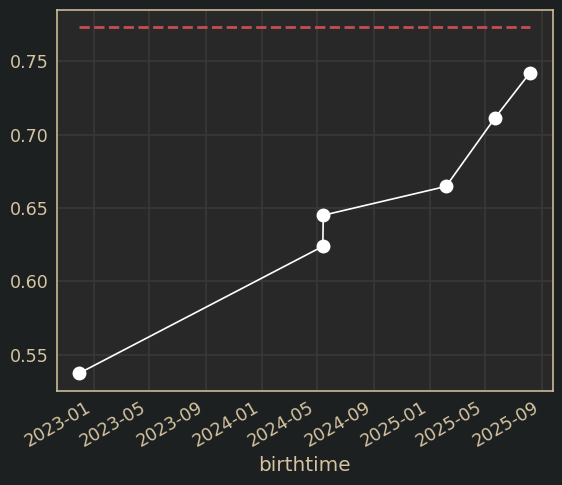

In [38]:
dh=df_.copy()
Jf=pd.DataFrame(NAMES,index=['source']).T
Jf.loc['human1']='human'
Jf1 = pd.DataFrame(
    {
        "source": [
             "human",
            "GPT-4o",
            "GPT-4o2",
            "GPT-3.5",
            "GPT-4.0",
            "Claude",# Sonnet 4",
            "Gemini",# 2.0 Flash (gemini-2.0-flash-001)",
            "GPT-5",
        ],
        "birthtime": pd.to_datetime(
            [
                "2026-05-13",
                "2024-05-13",
                "2024-05-14",
                "2022-11-30",
                "2023-03-14",
                "2025-05-22",
                "2025-02-05",
                "2025-08-07",
            ]
        ),
    }
)
J=pd.DataFrame({'ai2':ai2[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai3':ai3[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai1':ai1[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai0':ai0[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai4':ai4[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai5':ai5[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'ai6':ai6[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
   'human1':human1[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
  # human2[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
  },index=['mn']).T
Jstd=pd.DataFrame({'ai2':ai2[[x for x in dh.columns if 'rates' in x]].replace(0,None).std(axis=1).mean(),
   'ai3':ai3[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'ai0':ai0[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'ai1':ai1[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'ai4':ai4[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'ai5':ai5[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'ai6':ai6[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
   'human1':human1[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).std(),
  # human2[[x for x in dh.columns if 'rates' in x]].replace(0,None).median(axis=1).mean(),
  },index=['std']).T

JJ=J.join(Jf).join(Jstd).set_index('source').join(Jf1.set_index('source')).reset_index().set_index('birthtime').sort_index()
humanvalue=JJ.loc['2026-05-13','mn']
JJall=JJ.copy()
JJ=JJ.drop('2023-03-14')
JJ=JJ.drop('2026-05-13')	
#display(JJ)
#display(Jstd)
ax=JJ.mn.plot(style='-wo',markersize=10)#,logy=True,logx=True)
ax.plot(JJ.index.values,[humanvalue]*JJ.index.size,'--r',linewidth=2)

Richards (L0,k,x0,nu): [4.44094766e-01 6.16059282e-03 1.01469446e+03 5.00000000e+00]
Param SE: [2.28699987e+00 7.94103992e-02 4.88624402e+03 1.53588707e+02]
chi2: 0.12807367868027494 dof: 2 reduced chi2: 0.06403683934013747

Within 0.01 of U (>= 0.770000)
  Mean (point): 2026-07-02
  Fit band  delta  : upper 2023-07-07 | lower None
  Fit band  boot   : upper 2022-11-30 | lower None
  Pred band delta  : upper 2023-02-03 | lower None
  Pred band boot   : upper 2022-11-30 | lower None

Within 0.005 of U (>= 0.775000)
  Mean (point): 2026-10-30
  Fit band  delta  : upper 2023-07-20 | lower None
  Fit band  boot   : upper 2022-11-30 | lower None
  Pred band delta  : upper 2023-02-21 | lower None
  Pred band boot   : upper 2022-11-30 | lower None

Within 0.001 of U (>= 0.779000)
  Mean (point): None
  Fit band  delta  : upper 2023-08-01 | lower None
  Fit band  boot   : upper 2022-11-30 | lower None
  Pred band delta  : upper 2023-03-05 | lower None
  Pred band boot   : upper 2022-11-30 | lo

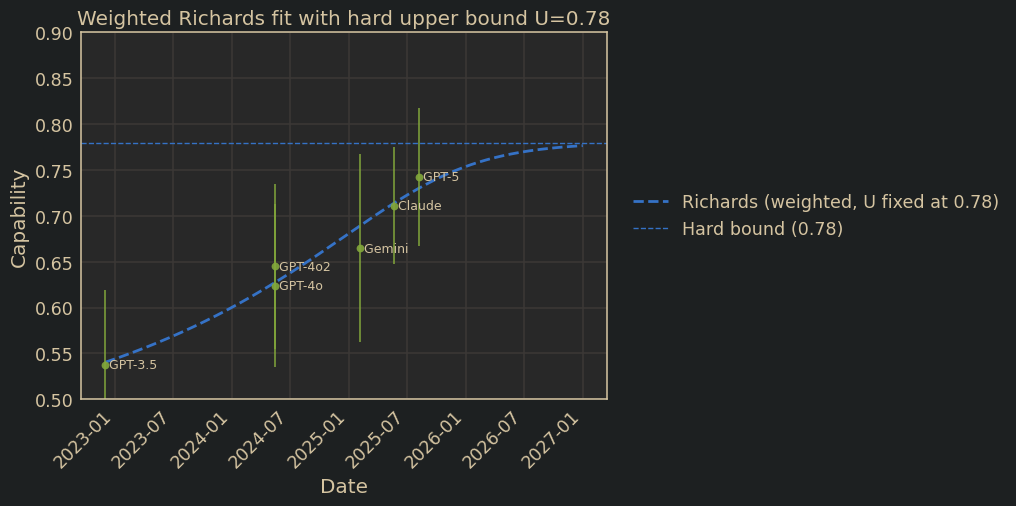

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------
# Prep
# -----------------------
JJ1 = JJ.reset_index()
JJ1.columns = ['birthtime','model','capability','std']
JJ1["birthtime"] = pd.to_datetime(JJ1["birthtime"])
JJ1 = JJ1.sort_values("birthtime")

t0 = JJ1["birthtime"].min()
x = (JJ1["birthtime"] - t0).dt.days.astype(float).to_numpy()
y = JJ1["capability"].to_numpy()
sigma = JJ1["std"].to_numpy()

U = 0.78  # HARD asymptotic upper bound (fixed)

# -----------------------
# Richards with fixed U
# -----------------------
def richards_fixedU(x, L0, k, x0, nu):
    return L0 + (U - L0) / ((1.0 + np.exp(-k * (x - x0))) ** (1.0/nu))

# -----------------------
# Weighted fit
# -----------------------
L0_0 = max(0.0, y.min() - 0.03)
x0_0 = float(np.median(x))
k_0  = 0.006
nu_0 = 0.6

popt, pcov = curve_fit(
    richards_fixedU, x, y,
    p0=[L0_0, k_0, x0_0, nu_0],
    bounds=([0.0, 1e-6, -2000.0, 0.05], [min(y)-1e-6, 3.0, 5000.0, 5.0]),
    sigma=sigma,
    absolute_sigma=True,
    maxfev=400000
)

# Diagnostics
res = richards_fixedU(x, *popt) - y
chi2 = float(np.sum((res / sigma)**2))
dof  = len(y) - len(popt)
rch2 = chi2 / dof if dof > 0 else np.nan
perr = np.sqrt(np.diag(pcov))

print("Richards (L0,k,x0,nu):", popt)
print("Param SE:", perr)
print("chi2:", chi2, "dof:", dof, "reduced chi2:", rch2)

# -----------------------
# Grid for plotting
# -----------------------
t_end = pd.to_datetime("2027-01-01")
grid_dates = pd.date_range(t0, t_end, freq="D")
grid_x = (grid_dates - t0).days.astype(float).to_numpy()

yhat = richards_fixedU(grid_x, *popt)

# -----------------------
# Delta-method bands
# -----------------------
def jacobian_fd(fun, x, p, eps=1e-6):
    p = np.array(p, dtype=float)
    x = np.atleast_1d(x).astype(float)
    J = np.zeros((x.size, p.size), dtype=float)
    for j in range(p.size):
        dp = np.zeros_like(p)
        dp[j] = eps * (abs(p[j]) + 1.0)
        f1 = fun(x, *(p + dp))
        f0 = fun(x, *(p - dp))
        J[:, j] = (f1 - f0) / (2.0 * dp[j])
    return J

J = jacobian_fd(richards_fixedU, grid_x, popt)
var_mean = np.einsum("ij,jk,ik->i", J, pcov, J)
se_mean = np.sqrt(np.maximum(var_mean, 0.0))

z = 1.96  # ~95%
fit_low  = yhat - z * se_mean
fit_high = yhat + z * se_mean

# Predictive band: mean uncertainty + observation noise.
# Need sigma on the grid; simplest is interpolate sigma vs x (piecewise-linear).
sigma_grid = np.interp(grid_x, x, sigma, left=sigma[0], right=sigma[-1])
se_pred = np.sqrt(se_mean**2 + sigma_grid**2)

pred_low  = yhat - z * se_pred
pred_high = yhat + z * se_pred

# -----------------------
# Parametric bootstrap (optional but recommended)
# -----------------------
def mvn_rvs(mean, cov, n, jitter=1e-12, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    # Jitter for numerical PSD issues
    C = cov + np.eye(cov.shape[0]) * jitter
    return rng.multivariate_normal(mean, C, size=n)

B = 5000
rng = np.random.default_rng(0)

# sample params from asymptotic normal approx
theta_s = mvn_rvs(popt, pcov, B, rng=rng)

# mean curves from param draws
Ymean = np.empty((B, grid_x.size), float)
for b in range(B):
    Ymean[b] = richards_fixedU(grid_x, *theta_s[b])

# predictive draws: add heteroscedastic noise on top of mean
Ypred = Ymean + rng.normal(0.0, sigma_grid[None, :], size=Ymean.shape)

boot_fit_low  = np.quantile(Ymean, 0.025, axis=0)
boot_fit_high = np.quantile(Ymean, 0.975, axis=0)

boot_pred_low  = np.quantile(Ypred, 0.025, axis=0)
boot_pred_high = np.quantile(Ypred, 0.975, axis=0)

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(6.5, 4.8))

plt.plot(grid_dates, yhat, linestyle='--', linewidth=2,
         label=f"Richards (weighted, U fixed at {U:.2f})")


plt.errorbar(JJ1["birthtime"], JJ1["capability"], yerr=JJ1["std"],
             fmt="o", capsize=3, alpha=0.9)

for _, r in JJ1.iterrows():
    plt.text(r["birthtime"], r["capability"], f" {r['model']}",
             va="center", fontsize=9)

plt.axhline(U, linestyle="--", linewidth=1, label=f"Hard bound ({U:.2f})")
plt.xlabel("Date")
plt.ylabel("Capability")
plt.title(f"Weighted Richards fit with hard upper bound U={U:.2f}")
plt.gca().set_ylim(0.5, 0.9)
plt.tight_layout()
plt.legend()

plt.xticks(rotation=45, ha="right")
ax = plt.gca()
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.tight_layout(rect=[0, 0, 0.78, 1])  # leave space on the right

# Threshold crossing: do it for both mean and predictive if you want
# -----------------------
def first_date_crossing(vals, target):
    idx = np.where(vals >= target)[0]
    return None if idx.size == 0 else grid_dates[idx[0]].date()

def crossing_report(eps):
    target = U - eps
    out = {}
    out["target"] = float(target)

    # mean curve
    out["point_mean"] = first_date_crossing(yhat, target)
    out["delta_fit_optimistic"] = first_date_crossing(fit_high, target)
    out["delta_fit_conservative"] = first_date_crossing(fit_low, target)

    out["boot_fit_optimistic"] = first_date_crossing(boot_fit_high, target)
    out["boot_fit_conservative"] = first_date_crossing(boot_fit_low, target)

    # predictive (interpretation: when typical single observations would exceed target)
    out["delta_pred_optimistic"] = first_date_crossing(pred_high, target)
    out["delta_pred_conservative"] = first_date_crossing(pred_low, target)

    out["boot_pred_optimistic"] = first_date_crossing(boot_pred_high, target)
    out["boot_pred_conservative"] = first_date_crossing(boot_pred_low, target)

    return out

for eps in [1e-2, 5e-3, 1e-3, 1e-4]:
    rep = crossing_report(eps)
    print(f"\nWithin {eps:g} of U (>= {rep['target']:.6f})")
    print("  Mean (point):", rep["point_mean"])
    print("  Fit band  delta  : upper", rep["delta_fit_optimistic"], "| lower", rep["delta_fit_conservative"])
    print("  Fit band  boot   : upper", rep["boot_fit_optimistic"],  "| lower", rep["boot_fit_conservative"])
    print("  Pred band delta  : upper", rep["delta_pred_optimistic"], "| lower", rep["delta_pred_conservative"])
    print("  Pred band boot   : upper", rep["boot_pred_optimistic"],  "| lower", rep["boot_pred_conservative"])


In [40]:
# -----------------------
# Save plot data for pgfplots
# -----------------------
import os

outdir = "plotdata"
os.makedirs(outdir, exist_ok=True)

# 1) Raw points (with labels)
df_points = JJ1[["birthtime", "model", "capability", "std"]].copy()
df_points["birthtime"] = df_points["birthtime"].dt.strftime("%Y-%m-%d")
df_points.to_csv(os.path.join(outdir, "points.csv"), index=False)

# 2) Grid curve + bands
df_curve = pd.DataFrame({
    "date": grid_dates.strftime("%Y-%m-%d"),
    "x_days": grid_x,          # optional, helpful if you want x as numeric
    "yhat": yhat,

    # delta-method mean (fit) band
    "fit_low": fit_low,
    "fit_high": fit_high,

    # delta-method predictive band
    "pred_low": pred_low,
    "pred_high": pred_high,

    # bootstrap mean (fit) band
    "boot_fit_low": boot_fit_low,
    "boot_fit_high": boot_fit_high,

    # bootstrap predictive band
    "boot_pred_low": boot_pred_low,
    "boot_pred_high": boot_pred_high,
})

df_curve.to_csv(os.path.join(outdir, "curve_and_bands.csv"), index=False)

# 3) Optional: constants (e.g., hard bound) in a tiny one-row CSV
pd.DataFrame({"U": [U], "t0": [t0.strftime("%Y-%m-%d")]}).to_csv(
    os.path.join(outdir, "constants.csv"), index=False
)

print("Wrote:",
      os.path.join(outdir, "points.csv"),
      os.path.join(outdir, "curve_and_bands.csv"),
      os.path.join(outdir, "constants.csv"))


Wrote: plotdata/points.csv plotdata/curve_and_bands.csv plotdata/constants.csv


In [41]:
df_points

,birthtime,model,capability,std
0,2022-11-30,GPT-3.5,0.537258,0.081778
1,2024-05-13,GPT-4o,0.623759,0.088751
2,2024-05-14,GPT-4o2,0.644955,0.089853
3,2025-02-05,Gemini,0.664616,0.102502
4,2025-05-22,Claude,0.711087,0.063883
5,2025-08-07,GPT-5,0.742249,0.075496


In [42]:
JJall.columns=['model','capability','std']

In [43]:
JJall[JJall.model!='human'].to_csv(os.path.join(outdir, "pointsall.csv"))